In [1]:
# Import packages
library(bnlearn)
library(visNetwork)


Attaching package: ‘bnlearn’

The following object is masked from ‘package:stats’:

    sigma



In [2]:
# Read in data
data_cont = read.csv(file="../data/DataMatrices/VansjøData_aut_forBN.csv", header=TRUE, sep=",", row.names = 1)
head(data_cont)

,chla,chla_lag1,chla_prevSummer,colour,colour_lag1,colour_prevSummer,Cyano,Cyano_lag1,Rain_lag1,Rainy_days_winter,TP,TP_lag1,TP_prevSummer,WindDays_under_Q0.4,WindDays_over_Q0.6
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1980,20.773333,12.169127,NA,NA,NA,NA,NA,NA,242.1992,NA,51.06190,36.08413,NA,38,33
1981,9.587500,7.075000,16.471230,NA,NA,NA,NA,NA,282.2578,102,34.08333,23.58333,43.57302,41,29
1982,6.229167,5.466667,8.331250,26.66667,NA,NA,NA,NA,151.0062,105,18.89583,37.77778,28.83333,28,47
1983,6.166667,5.980000,5.847917,14.66667,19.40000,26.66667,NA,NA,182.7288,121,26.15000,31.96000,28.33681,25,51
1984,11.950000,10.230000,6.073333,NA,NA,17.03333,NA,NA,255.8206,121,25.69500,27.36000,29.05500,35,31
1985,13.333333,9.977778,11.090000,34.62500,34.11111,NA,NA,NA,236.4939,138,26.72500,36.60000,26.52750,39,40


In [3]:
# Create an empty DAG with the desired nodes
dag =      empty.graph(c('chla',
                         'chla_lag1',
                         'chla_prevSummer',
                         'colour',
                         'colour_lag1',
                         'colour_prevSummer',
                         'Cyano',
                         'Cyano_lag1',
                         'Rain_lag1',
                         'Rainy_days_winter',
                         'TP',
                         'TP_lag1',
                         'TP_prevSummer',
                         'WindDays_under_Q0.4',
                         'WindDays_over_Q0.6'))

# Manually define the arcs connecting nodes
arcs_matrix = matrix(c('TP_prevSummer','TP',
                       'TP_lag1','TP',
                       'TP','chla',
                       'chla_prevSummer','chla',
                       'Rainy_days_winter','chla',
                       'WindDays_over_Q0.6','chla',
                       'chla_lag1','chla',
                       'chla','Cyano',
                       'WindDays_under_Q0.4','Cyano',
                       'Cyano_lag1','Cyano',
                       'colour','Cyano',
                       'colour_prevSummer','colour',
                       'Rain_lag1','colour',
                       'colour_lag1','colour'),
                        ncol = 2, byrow = TRUE,
                        dimnames = list(NULL, c("from", "to"))) #assign the DAG structure (as an attribute of asia)
arcs_matrix

from,to
TP_prevSummer,TP
TP_lag1,TP
TP,chla
chla_prevSummer,chla
Rainy_days_winter,chla
WindDays_over_Q0.6,chla
chla_lag1,chla
chla,Cyano
WindDays_under_Q0.4,Cyano
Cyano_lag1,Cyano


In [4]:
# Assign the structure to the empty graph using arcs, which turns it into a bnlearn object
arcs(dag) = arcs_matrix
dag


  Random/Generated Bayesian network

  model:
   [chla_lag1][chla_prevSummer][colour_lag1][colour_prevSummer][Cyano_lag1]
   [Rain_lag1][Rainy_days_winter][TP_lag1][TP_prevSummer][WindDays_under_Q0.4]
   [WindDays_over_Q0.6][colour|colour_lag1:colour_prevSummer:Rain_lag1]
   [TP|TP_lag1:TP_prevSummer]
   [chla|chla_lag1:chla_prevSummer:Rainy_days_winter:TP:WindDays_over_Q0.6]
   [Cyano|chla:colour:Cyano_lag1:WindDays_under_Q0.4]
  nodes:                                 15 
  arcs:                                  14 
    undirected arcs:                     0 
    directed arcs:                       14 
  average markov blanket size:           4.53 
  average neighbourhood size:            1.87 
  average branching factor:              0.93 

  generation algorithm:                  Empty 


In [5]:
# Plot the network. Cand do this just using plot(structure), but it doesn't look nice. Instead, use the interactive plotting package visNetwork

# Define a function to create nice interactive plots
plot.network = function(structure, ht="400px")
    {
      nodes.uniq <- unique(c(structure$arcs[,1], structure$arcs[,2]))
      nodes <- data.frame(id = nodes.uniq,
                          label = nodes.uniq,
                          color = "darkturquoise",
                          shadow = FALSE)

      edges <- data.frame(from = structure$arcs[,1],
                          to = structure$arcs[,2],
                          arrows = "to",
                          smooth = TRUE,
                          shadow = FALSE,
                          color = "black")

      return(visNetwork(nodes, edges, height = ht, width = "100%"))
    }

plot.network(dag)

HTML widgets cannot be represented in plain text (need html)

## Assume all nodes are continuous

First, lets just ignore the fact that some nodes aren't Gaussians, and have a go at fitting to the raw data

In [7]:
ncol(data_cont) # but the late summer dag has 15
nrow(data_cont)

[1] 15

[1] 38

In [11]:
# Fit parameters
data_cont[1:ncol(data_cont)] = lapply(data_cont[1:ncol(data_cont)], as.numeric) # First, convert data type of integers to numeric

fit = bn.fit(dag, data_cont)
fit


  Bayesian network parameters

  Parameters of node chla (Gaussian distribution)

Conditional density: chla | chla_lag1 + chla_prevSummer + Rainy_days_winter + TP + WindDays_over_Q0.6
Coefficients:
       (Intercept)           chla_lag1     chla_prevSummer   Rainy_days_winter  
      -17.24799142         -0.24700061          0.05078118          0.19449789  
                TP  WindDays_over_Q0.6  
        0.68255066         -0.30591327  
Standard deviation of the residuals: 4.239585 

  Parameters of node chla_lag1 (Gaussian distribution)

Conditional density: chla_lag1
Coefficients:
(Intercept)  
   14.72071  
Standard deviation of the residuals: 6.254342 

  Parameters of node chla_prevSummer (Gaussian distribution)

Conditional density: chla_prevSummer
Coefficients:
(Intercept)  
   15.82884  
Standard deviation of the residuals: 5.777146 

  Parameters of node colour (Gaussian distribution)

Conditional density: colour | colour_lag1 + colour_prevSummer + Rain_lag1
Coefficients:
  

Loading required namespace: lattice


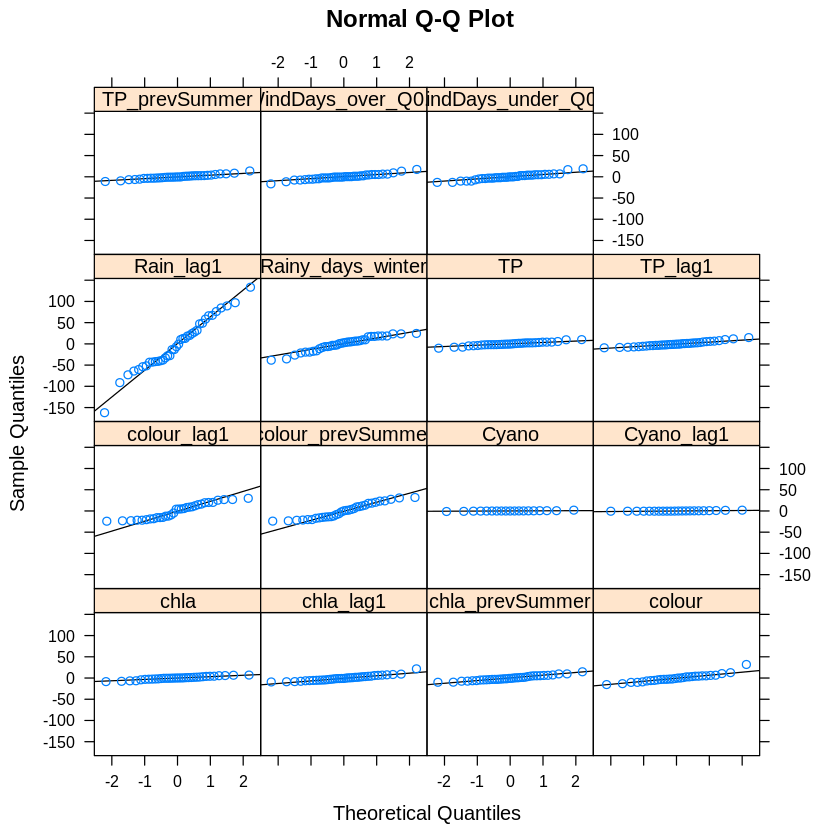

In [12]:
bn.fit.qqplot(fit)